# Data Science  - Unit 2.1.4
Name: Michael Luo

Date: 2022/10/29

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Logistic Regression

Do you like burritos? 🌯 You're in luck then, because in this project you'll create a model to predict whether a burrito is `'Great'`.

The dataset for this assignment comes from [Scott Cole](https://srcole.github.io/100burritos/), a San Diego-based data scientist and burrito enthusiast. 

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function .
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build `model_logr` using a pipeline that includes three transfomers and `LogisticRegression` predictor. Train model on `X_train` and `X_test`.
- **Task 7:** Calculate the training and test accuracy score for your model.
- **Task 8:** Create a horizontal bar chart showing the 10 most influencial features for your  model. 
- **Task 9:** Demonstrate and explain the differences between `model_lr.predict()` and `model_lr.predict_proba()`.

**Note** 

You should limit yourself to the following libraries:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

In [ ]:
import pandas as pd
import numpy as np

#encoding, preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

#sklearn & modelling
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# I. Wrangle Data

In [ ]:
def wrangle(filepath):
    # Import w/ DateTimeIndex
    df = pd.read_csv(filepath, parse_dates=['Date'],
                     index_col='Date')
    
    # Drop unrated burritos
    df.dropna(subset=['overall'], inplace=True)
    
    # Derive binary classification target:
    # We define a 'Great' burrito as having an
    # overall rating of 4 or higher, on a 5 point scale
    df['Great'] = (df['overall'] >= 4).astype(int)
    
    # Drop high cardinality categoricals
    df = df.drop(columns=['Notes', 'Location', 'Address', 'URL', 'Neighborhood'])
    
    # Drop columns to prevent "leakage"
    df = df.drop(columns=['Rec', 'overall'])

    #drop constant cols
    cols_const = [col for col, nunique in df.nunique().items() if nunique == 0]
    df.drop(columns=cols_const, inplace = True)
    
    #Manually fix chips: binary col with 4 unique values
    df['Chips'] = df['Chips'].str.upper().map({'X':'X', 'YES':'X', 'NO':np.NaN})

    #clean up binary columns 
    cols_binary = [col for col, nunique in df.astype(str).applymap(str.upper).nunique().items() if nunique == 2]
    cols_binary.remove('Great') #exclude target
    #DEBUG print(cols_binary)
    df.loc[:, cols_binary] = df[cols_binary].notnull().astype(int)
  
    #Stretch Goal: Encode type of burrito
    df['b_california'] = df['Burrito'].str.lower().str.contains(r'cali').astype('int')
    df['b_asada'] = df['Burrito'].str.lower().str.contains(r'asada').astype('int')
    df['b_surf'] = df['Burrito'].str.lower().str.contains(r'surf').astype('int')
    df['b_carnitas'] = df['Burrito'].str.lower().str.contains(r'carnitas').astype('int')
    df.drop(columns='Burrito', inplace=True)
    
    return df.sort_index()

filepath = DATA_PATH + 'burritos/burritos.csv'

**Task 1:** Use the above `wrangle` function to import the `burritos.csv` file into a DataFrame named `df`.

In [ ]:
filepath = DATA_PATH + 'burritos/burritos.csv'
df = wrangle(filepath)

During your exploratory data analysis, note that there are several columns whose data type is `object` but that seem to be a binary encoding. For example, `df['Beef'].head()` returns:

```
0      x
1      x
2    NaN
3      x
4      x
Name: Beef, dtype: object
```

**Task 2:** Change the `wrangle` function so that these columns are properly encoded as `0` and `1`s. Be sure your code handles upper- and lowercase `X`s, and `NaN`s.

In [ ]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,...,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,0,6.49,3.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,0,0
2016-01-24,California,3.5,3.3,0,5.45,3.5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,0,0
2016-01-24,Carnitas,NaN,NaN,0,4.85,1.5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,0,0
2016-01-24,Carne asada,NaN,NaN,0,5.25,2.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,0,0
2016-01-27,California,4.0,3.8,1,6.59,4.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2011-05-16 to 2026-04-25
Data columns (total 61 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Yelp            87 non-null     float64
 1   Google          87 non-null     float64
 2   Chips           421 non-null    int64  
 3   Cost            414 non-null    float64
 4   Hunger          418 non-null    float64
 5   Mass (g)        22 non-null     float64
 6   Density (g/mL)  22 non-null     float64
 7   Length          283 non-null    float64
 8   Circum          281 non-null    float64
 9   Volume          281 non-null    float64
 10  Tortilla        421 non-null    float64
 11  Temp            401 non-null    float64
 12  Meat            407 non-null    float64
 13  Fillings        418 non-null    float64
 14  Meat:filling    412 non-null    float64
 15  Uniformity      419 non-null    float64
 16  Salsa           396 non-null    float64
 17  Synergy         

In [ ]:
df.nunique()

Burrito           132
Yelp                6
Google             18
Chips               2
Cost               98
Hunger             25
Mass (g)           18
Density (g/mL)     21
Length             29
Circum             30
Volume             64
Tortilla           18
Temp               18
Meat               23
Fillings           22
Meat:filling       25
Uniformity         28
Salsa              27
Synergy            27
Wrap               23
Reviewer          106
Unreliable          2
NonSD               2
Beef                2
Pico                2
Guac                2
Cheese              2
Fries               2
Sour cream          2
Pork                2
Chicken             2
Shrimp              2
Fish                2
Rice                2
Beans               2
Lettuce             2
Tomato              2
Bell peper          2
Carrots             2
Cabbage             2
Sauce               2
Salsa.1             2
Cilantro            2
Onion               2
Taquito             2
Pineapple 

In [ ]:
df.nunique()

Burrito           132
Yelp                6
Google             18
Chips               2
Cost               98
Hunger             25
Mass (g)           18
Density (g/mL)     21
Length             29
Circum             30
Volume             64
Tortilla           18
Temp               18
Meat               23
Fillings           22
Meat:filling       25
Uniformity         28
Salsa              27
Synergy            27
Wrap               23
Reviewer          106
Unreliable          2
NonSD               2
Beef                2
Pico                2
Guac                2
Cheese              2
Fries               2
Sour cream          2
Pork                2
Chicken             2
Shrimp              2
Fish                2
Rice                2
Beans               2
Lettuce             2
Tomato              2
Bell peper          2
Carrots             2
Cabbage             2
Sauce               2
Salsa.1             2
Cilantro            2
Onion               2
Taquito             2
Pineapple 

If you explore the `'Burrito'` column of `df`, you'll notice that it's a high-cardinality categorical feature. You'll also notice that there's a lot of overlap between the categories. 

**Stretch Goal:** Change the `wrangle` function above so that it engineers four new features: `'california'`, `'asada'`, `'surf'`, and `'carnitas'`. Each row should have a `1` or `0` based on the text information in the `'Burrito'` column. For example, here's how the first 5 rows of the dataset would look.

| **Burrito** | **california** | **asada** | **surf** | **carnitas** |
| :---------- | :------------: | :-------: | :------: | :----------: |
| California  |       1        |     0     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |
|  Carnitas   |       0        |     0     |    0     |      1       |
| Carne asada |       0        |     1     |    0     |      0       |
| California  |       1        |     0     |    0     |      0       |

**Note:** Be sure to also drop the `'Burrito'` once you've engineered your new features.

In [ ]:
# Conduct your exploratory data analysis here
# And modify the `wrangle` function above.

# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'Great'`.

In [ ]:
target = 'Great'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from 2016 through 2017. 
- Your test set should include data from 2018 and later.

In [ ]:
#Check date ranges
df.index.max(), df.index.min()

(Timestamp('2026-04-25 00:00:00'), Timestamp('2011-05-16 00:00:00'))

In [ ]:
mask_train = (X.index > '2016') & (X.index < '2018')
mask_test = (X.index >= '2018')

X_train, y_train = X[mask_train], y[mask_train]
X_test, y_test = X[mask_test], y[mask_test]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(381, 60) (381,)
(38, 60) (38,)


# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents. 

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5826771653543307


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_logr`, and fit it to your training data. Your pipeline should include:

- a `OneHotEncoder` transformer for categorical features, 
- a `SimpleImputer` transformer to deal with missing values, 
- a [`StandarScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) transfomer (which often improves performance in a logistic regression model), and 
- a `LogisticRegression` predictor.

In [ ]:
#Impute vs encoding 1st/second for categorical columns:

#Impute first with mode -> encode -> no NaN
  #useful if classes are known to be from an EXACT set

#Encode first -> NaN becomes its own 'category', all sub features are 0
  #useful if EXACT set of classes are not known, then NaN is its own category

In [ ]:
model_logr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'), #Imputes over every column of the data, including object type. #HOWEVER since we encoded first, there will be no NaN values
    StandardScaler(),
    LogisticRegression()
)

model_logr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Reviewer'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
#useful pipeline attributes

model_logr.named_steps

#examples

# model_logr.named_steps['onehotencoder'].get_feature_names()

['Yelp',
 'Google',
 'Chips',
 'Cost',
 'Hunger',
 'Mass (g)',
 'Density (g/mL)',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap',
 'Reviewer_Scott',
 'Reviewer_Ricardo',
 'Reviewer_Emily',
 'Reviewer_Marc',
 'Reviewer_Nicole',
 'Reviewer_Cris',
 'Reviewer_Leo',
 'Reviewer_Sage',
 'Reviewer_Eli',
 'Reviewer_Kelsey',
 'Reviewer_Jake',
 'Reviewer_Torben',
 'Reviewer_Alex',
 'Reviewer_Richard',
 'Reviewer_Tom',
 'Reviewer_Brad',
 'Reviewer_Tara',
 'Reviewer_Andy',
 'Reviewer_Bankole',
 'Reviewer_Erin',
 'Reviewer_Luis',
 'Reviewer_Karl',
 'Reviewer_Kalen',
 'Reviewer_Brent',
 'Reviewer_Chuck K',
 'Reviewer_Elynn',
 'Reviewer_Sandra',
 'Reviewer_Sankeerth',
 'Reviewer_Katie',
 'Reviewer_Matteo',
 'Reviewer_Aga',
 'Reviewer_Sai G',
 'Reviewer_Laya',
 'Reviewer_nan',
 'Reviewer_Damien B',
 'Reviewer_Sarah',
 'Reviewer_Jonathan G',
 'Reviewer_Brittany T',
 'Reviewer_Kevin',
 'Reviewer_Gurkirat S',
 'Rev

# IV. Check Metrics

**Task 7:** Calculate the training and test accuracy score for `model_lr`.

In [ ]:
training_acc = model_logr.score(X_train, y_train)
test_acc = model_logr.score(X_test, y_test)

print('Training MAE:', training_acc)
print('Test MAE:', test_acc)

Training MAE: 0.973753280839895
Test MAE: 0.7894736842105263


# V. Communicate Results

**Task 8:** Create a horizontal barchart that plots the 10 most important coefficients for `model_lr`, sorted by absolute value.

**Note:** Since you created your model using a `Pipeline`, you'll need to use the [`named_steps`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) attribute to access the coefficients in your `LogisticRegression` predictor. Be sure to look at the shape of the coefficients array before you combine it with the feature names.

In [ ]:
# Create your horizontal barchart here.

In [ ]:
model_logr.named_steps

{'onehotencoder': OneHotEncoder(cols=['Reviewer'], use_cat_names=True),
 'simpleimputer': SimpleImputer(),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression()}

In [ ]:
logr = model_logr.named_steps['logisticregression']

coefs = logr.coef_[0]
features = model_logr.named_steps['onehotencoder'].get_feature_names()

df_coefs = pd.DataFrame(coefs, index=features, columns=['coefs']).abs().sort_values(by='coefs', ascending=False).head(10)

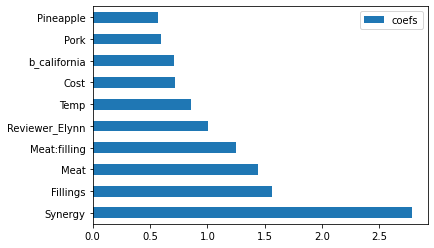

In [ ]:
df_coefs.plot.barh()

There is more than one way to generate predictions with `model_lr`. For instance, you can use [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression) or [`predict_proba`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression.predict_proba).

**Task 9:** Generate predictions for `X_test` using both `predict` and `predict_proba`. Then below, write a summary of the differences in the output for these two methods. You should answer the following questions:

- What data type do `predict` and `predict_proba` output?
- What are the shapes of their different output?
- What numerical values are in the output?
- What do those numerical values represent?

In [ ]:
# Write code here to explore the differences between `predict` and `predict_proba`.
y_predict_class = model_logr.predict(X_test)
print(y_predict_class)

y_predict_proba = model_logr.predict_proba(X_test)
print(y_predict_proba)

[1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1
 1]
[[1.10682572e-03 9.98893174e-01]
 [9.51586832e-01 4.84131682e-02]
 [9.99610621e-01 3.89379172e-04]
 [3.74257841e-05 9.99962574e-01]
 [9.71756512e-01 2.82434884e-02]
 [5.60443003e-05 9.99943956e-01]
 [4.90264353e-05 9.99950974e-01]
 [1.52224059e-02 9.84777594e-01]
 [1.70132741e-01 8.29867259e-01]
 [7.68875713e-01 2.31124287e-01]
 [9.72482937e-01 2.75170632e-02]
 [3.65854676e-01 6.34145324e-01]
 [3.39443023e-01 6.60556977e-01]
 [1.79114946e-02 9.82088505e-01]
 [2.70245821e-02 9.72975418e-01]
 [4.76152420e-02 9.52384758e-01]
 [9.97360370e-01 2.63962984e-03]
 [9.98656547e-01 1.34345338e-03]
 [9.99593370e-01 4.06630024e-04]
 [9.97538125e-01 2.46187539e-03]
 [4.93093423e-03 9.95069066e-01]
 [9.57645229e-01 4.23547710e-02]
 [4.23825591e-02 9.57617441e-01]
 [4.00241253e-01 5.99758747e-01]
 [9.34447510e-01 6.55524895e-02]
 [9.97485865e-01 2.51413545e-03]
 [1.64321850e-05 9.99983568e-01]
 [5.34635738e-02 9.46536426e-0

**Give your written answer here:**

```
The predict method outputs the predicted class only and the shape is equal to y_test. The predict_proba method outputs the probability for each class. In this case, its output is in the shape of (y_test, N classes)

```